<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/06_policy_decision_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import joblib
import shap
import json
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

drive.mount('/content/drive')


# Dataset path (update if different)
DATASET = "/content/drive/My Drive/obesity-risk-analytics/data/processed_final"

Mounted at /content/drive


In [ ]:
df_final = pd.read_csv(
    os.path.join(DATASET, "df_final_with_predictions.csv"),
    dtype={"GEOID": str}
)

df_final["GEOID"] = df_final["GEOID"].str.zfill(5)

In [ ]:
best_model_final = joblib.load("/content/drive/My Drive/obesity-risk-analytics/data/processed_final/final_gradient_boosting_model.pkl")

print("Final model loaded successfully")

Final model loaded successfully


In [ ]:
df_final

,GEOID,CTYNAME,STNAME,obesity_rate,physical_inactivity_rate,poverty_rate,low_access_food_rate,median_household_income,unemployment_rate,risk_score_all,...,risk_rank_heal,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,predicted_obesity,residual,high_obesity,abs_error
0,09001,NaN,NaN,0.222000,0.189000,0.090000,0.486825,96966.0,0.035162,-4.753117,...,2883.0,0.845836,0.033922,0.045702,0.007092,0.008037,0.264415,-0.042415,0,0.042415
1,09003,NaN,NaN,0.293000,0.209000,0.108000,0.497841,75336.0,0.037397,-3.550985,...,2433.0,0.845836,0.033922,0.045702,0.007092,0.008037,0.274677,0.018323,0,0.018323
2,09007,NaN,NaN,0.274000,0.198000,0.070000,0.600196,81721.0,0.030787,-4.577700,...,2643.0,0.845836,0.033922,0.045702,0.007092,0.008037,0.277063,-0.003063,0,0.003063
3,09009,NaN,NaN,0.310000,0.223000,0.120000,0.572042,69687.0,0.037745,-1.910094,...,1931.0,0.845836,0.033922,0.045702,0.007092,0.008037,0.285623,0.024377,0,0.024377
4,09011,NaN,NaN,0.307001,0.218001,0.078000,0.578048,75226.0,0.034857,-2.466703,...,2094.0,0.845836,0.033922,0.045702,0.007092,0.008037,0.287434,0.019567,0,0.019567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,56037,Sweetwater County,Wyoming,0.340004,0.217006,0.083001,0.339748,80639.0,0.039985,-2.109221,...,2336.0,0.939437,0.013177,0.164135,0.009723,0.014502,0.287941,0.052063,1,0.052063
3117,56039,Teton County,Wyoming,0.154001,0.122003,0.060002,0.322673,98837.0,0.028209,-13.012932,...,3118.0,0.948986,0.007845,0.141638,0.015218,0.009817,0.183447,-0.029446,0,0.029446
3118,56041,Uinta County,Wyoming,0.283016,0.247014,0.085001,0.000000,70756.0,0.039644,-0.446029,...,1707.0,0.954910,0.006406,0.096929,0.004793,0.015209,0.294092,-0.011076,0,0.011076
3119,56043,Washakie County,Wyoming,0.246022,0.215032,0.111009,0.389781,55122.0,0.041312,-3.825525,...,2357.0,0.948731,0.004945,0.140924,0.008198,0.016786,0.266354,-0.020332,0,0.020332


In [ ]:
economic_features = [
    "poverty_rate",
    "median_household_income",
    "unemployment_rate",
]

health_features = [
    "physical_inactivity_rate",
    "low_access_food_rate",
]

demo_features = [
    "pct_white",
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    "pct_native"
]

all_features = economic_features + health_features + demo_features
target_col = "obesity_rate"

In [ ]:
X = df_final[all_features].copy()
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

In [ ]:

X_all = df_final[all_features].copy()
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(X_all.median())

test_preds = best_model_final.predict(X_all)

test_preds[:5]


array([0.26441485, 0.27467663, 0.27706322, 0.2856232 , 0.28743402])

# SHAP

In [ ]:
X_shap = df_final[all_features].copy()
X_shap = X_shap.apply(pd.to_numeric, errors="coerce")
X_shap = X_shap.fillna(X_shap.median())

In [ ]:
def predict_fn(X):
    return best_model_final.predict(X)

explainer = shap.Explainer(predict_fn, X_shap)
shap_values = explainer(X_shap)

ExactExplainer explainer: 3122it [41:40,  1.25it/s]


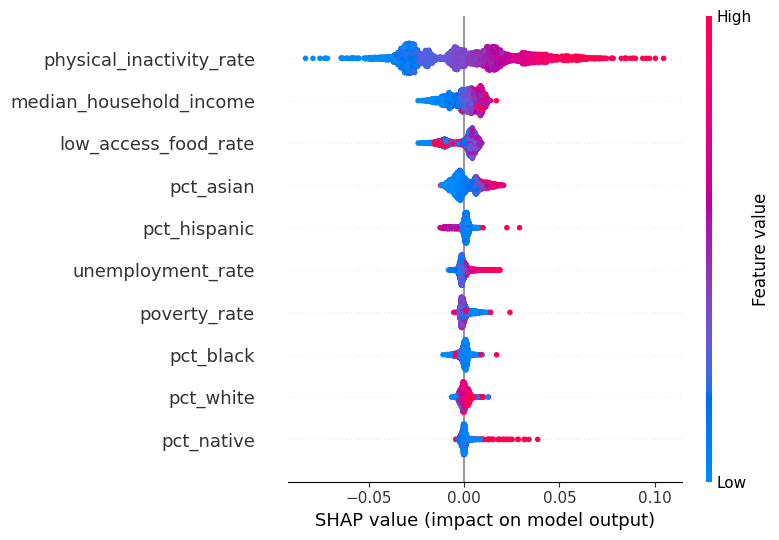

In [ ]:
shap.summary_plot(shap_values, X_shap)

# Policy Simulation

In [ ]:
baseline_preds = best_model_final.predict(X_shap)
baseline_mean = baseline_preds.mean()

baseline_mean


np.float64(0.2877531115872211)

Physical inactivity

In [ ]:
X_sim = X_shap.copy()
X_sim["physical_inactivity_rate"] *= 0.90   # 10% reduction

simulated_preds = best_model_final.predict(X_sim)
simulated_mean = simulated_preds.mean()

simulated_mean


np.float64(0.2721863126681285)

In [ ]:
impact = baseline_mean - simulated_mean
impact


np.float64(0.015566798919092628)

Low Food Access

In [ ]:
X_sim_food = X_shap.copy()
X_sim_food["low_access_food_rate"] *= 0.90  # 10% improvement
sim_food_preds = best_model_final.predict(X_sim_food)

impact_food = baseline_mean - sim_food_preds.mean()
impact_food

np.float64(-0.00046737049498962735)

Income

In [ ]:
X_sim_income = X_shap.copy()
X_sim_income["median_household_income"] *= 1.10  # 10% income increase
sim_income_preds = best_model_final.predict(X_sim_income)

impact_income = baseline_mean - sim_income_preds.mean()
impact_income


np.float64(-0.0024779915379731787)

In [ ]:
X_sim_combo = X_shap.copy()
X_sim_combo["physical_inactivity_rate"] *= 0.90
X_sim_combo["median_household_income"]    *= 1.80
sim_combo_preds = best_model_final.predict(X_sim_combo)

impact_combo = baseline_mean - sim_combo_preds.mean()
impact_combo

np.float64(0.010735425651368147)

# Interaction Analysis

In [ ]:
# INTERACTION FEATURES

df_interact = df_final.copy()

# Poverty × Race interactions
# df_interact["poverty_x_black"] = df_interact["poverty_rate"] * df_interact["pct_black"]
# df_interact["poverty_x_hispanic"] = df_interact["poverty_rate"] * df_interact["pct_hispanic"]
# df_interact["poverty_x_native"] = df_interact["poverty_rate"] * df_interact["pct_native"]
# df_interact["poverty_x_asian"] = df_interact["poverty_rate"] * df_interact["pct_asian"]
# df_interact["poverty_x_white"] = df_interact["poverty_rate"] * df_interact["pct_white"]

# Poverty × Behavior / Access
# df_interact["poverty_x_inactivity"] = df_interact["poverty_rate"] * df_interact["physical_inactivity_rate"]
# df_interact["poverty_x_food_access"] = df_interact["poverty_rate"] * df_interact["low_access_food_rate"]

# Behavior × Income buffering / Access
# df_interact["inactivity_x_income"] = df_interact["physical_inactivity_rate"] * df_interact["median_household_income"]


# Behaviour x Access
# df_interact["inactivity_x_food_access"] = df_interact["physical_inactivity_rate"] * df_interact["low_access_food_rate"]
#Income x Access
# df_interact["income_x_food_access"] = df_interact["median_household_income"] * df_interact["low_access_food_rate"]

# Income x Race Interactions
df_interact["income_x_black"] = df_interact["median_household_income"] * df_interact["pct_black"]
df_interact["income_x_asian"] = df_interact["median_household_income"] * df_interact["pct_asian"]
df_interact["income_x_white"] = df_interact["median_household_income"] * df_interact["pct_white"]
df_interact["income_x_hispanic"] = df_interact["median_household_income"] * df_interact["pct_hispanic"]

# Behavior x Race interactions
# df_interact["inactivity_x_black"] = df_interact["physical_inactivity_rate"] * df_interact["pct_black"]
# df_interact["inactivity_x_asian"] = df_interact["physical_inactivity_rate"] * df_interact["pct_asian"]
# df_interact["inactivity_x_white"] = df_interact["physical_inactivity_rate"] * df_interact["pct_white"]
# df_interact["inactivity_x_hispanic"] = df_interact["physical_inactivity_rate"] * df_interact["pct_hispanic"]

print("Interaction features added:",
      [c for c in df_interact.columns if "_x_" in c])


Interaction features added: ['income_x_black', 'income_x_asian', 'income_x_white', 'income_x_hispanic']


In [ ]:
interaction_features = [
    # "poverty_x_black",
    # "poverty_x_hispanic",
    # "poverty_x_native",
    # "poverty_x_asian",
    # "poverty_x_white",
    # "poverty_x_inactivity",
    # "poverty_x_food_access",
    # "inactivity_x_income",
    "income_x_black",
    "income_x_asian",
    "income_x_white",
    "income_x_hispanic"
    # "inactivity_x_black",
    # "inactivity_x_asian",
    # "inactivity_x_white",
    # "inactivity_x_hispanic",
    # "inactivity_x_food_access"
    # "income_x_food_access",

]

# all_features_interact = all_features + interaction_features
all_features_interact = interaction_features


In [ ]:
X_interact = df_interact[all_features_interact].copy()
X_interact = X_interact.apply(pd.to_numeric, errors="coerce")
X_interact = X_interact.fillna(X_interact.median())

y = df_interact["obesity_rate"].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_interact, y, test_size=0.2, random_state=42
)

model_interact = GradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200
)

model_interact.fit(X_train, y_train)
y_pred_interact = model_interact.predict(X_test)

r2_interact = r2_score(y_test, y_pred_interact)
rmse_interact = np.sqrt(mean_squared_error(y_test, y_pred_interact))

print("INTERACTION MODEL RESULTS")
print("R²   :", r2_interact)
print("RMSE :", rmse_interact)


INTERACTION MODEL RESULTS
R²   : 0.06912036896526952
RMSE : 0.04699488614515919


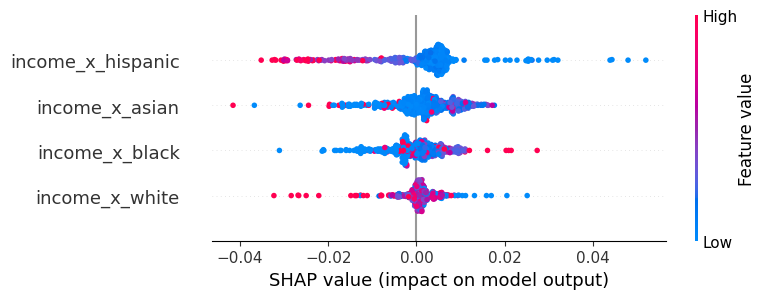

In [ ]:
X_shap_interact = X_interact.sample(500, random_state=42)

def predict_fn_interact(X):
    return model_interact.predict(X)

explainer_interact = shap.Explainer(predict_fn_interact, X_shap_interact)
shap_values_interact = explainer_interact(X_shap_interact)

shap.summary_plot(shap_values_interact, X_shap_interact)


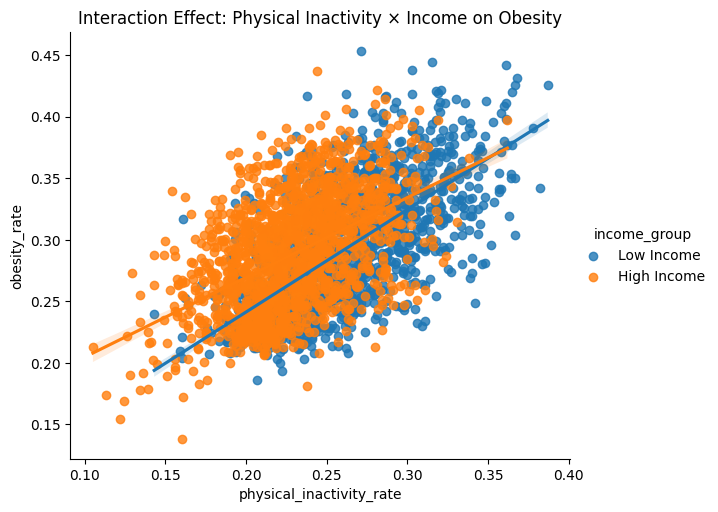

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_plot = df_interact.copy()
df_plot["income_group"] = pd.qcut(
    df_plot["median_household_income"],
    2, labels=["Low Income", "High Income"]
)

sns.lmplot(
    data=df_plot,
    x="physical_inactivity_rate",
    y="obesity_rate",
    hue="income_group",
    height=5,
    aspect=1.2
)

plt.title("Interaction Effect: Physical Inactivity × Income on Obesity")
plt.show()

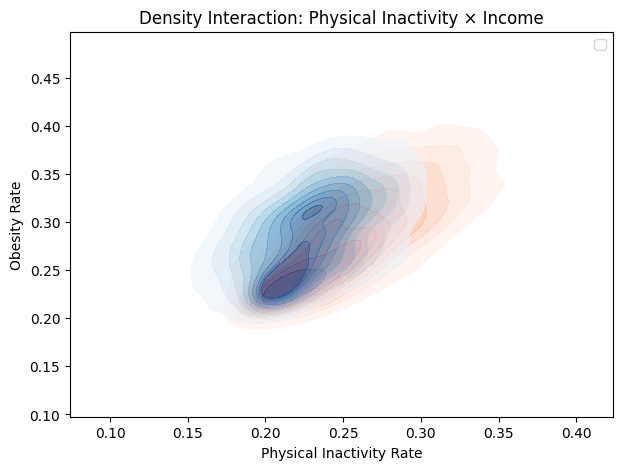

In [ ]:
plt.figure(figsize=(7,5))

for group, color in zip(["Low Income", "High Income"], ["Reds", "Blues"]):
    sns.kdeplot(
        data=df_plot[df_plot["income_group"] == group],
        x="physical_inactivity_rate",
        y="obesity_rate",
        fill=True,
        cmap=color,
        alpha=0.6,
        thresh=0.1
    )

plt.xlabel("Physical Inactivity Rate")
plt.ylabel("Obesity Rate")
plt.title("Density Interaction: Physical Inactivity × Income")
plt.legend(labels=["Low Income Density", "High Income Density"])
plt.show()


# Efficiency Map

In [ ]:
df_final["baseline_pred"] = baseline_preds
df_final["simulated_pred"] = simulated_preds

df_final["obesity_reduction_potential"] = (
    df_final["baseline_pred"] - df_final["simulated_pred"]
)


In [ ]:
df_final["efficiency_score"] = (
    df_final["obesity_reduction_potential"] /
    df_final["physical_inactivity_rate"]
)


In [ ]:
top_10pct_efficiency = df_final.sort_values(
    "efficiency_score", ascending=False
).head(int(0.10 * len(df_final)))

top_10pct_efficiency[
    ["GEOID", "CTYNAME", "STNAME",
     "physical_inactivity_rate",
     "obesity_reduction_potential",
     "efficiency_score"]
]


,GEOID,CTYNAME,STNAME,physical_inactivity_rate,obesity_reduction_potential,efficiency_score
2682,46102,Oglala Lakota County,South Dakota,0.238011,0.068435,0.287530
2142,28133,Sunflower County,Mississippi,0.303003,0.084261,0.278085
478,24017,Charles County,Maryland,0.244001,0.062016,0.254161
952,48215,Hidalgo County,Texas,0.271000,0.066999,0.247227
68,04027,Yuma County,Arizona,0.226001,0.053629,0.237297
...,...,...,...,...,...,...
1742,20155,Reno County,Kansas,0.258005,0.031485,0.122031
1560,16063,Lincoln County,Idaho,0.227054,0.027696,0.121979
561,29053,Cooper County,Missouri,0.237001,0.028909,0.121978
2619,45011,Barnwell County,South Carolina,0.296011,0.036051,0.121788


# MCDM vs SUPERVISED MISMATCH

In [ ]:
df_final["risk_score_norm"] = (
    df_final["risk_score_all"] - df_final["risk_score_all"].mean()
) / df_final["risk_score_all"].std()

df_final["residual_norm"] = (
    df_final["residual"] - df_final["residual"].mean()
) / df_final["residual"].std()


In [ ]:
def classify_policy_group(row):
    if row["risk_score_norm"] > 0 and row["residual_norm"] > 0:
        return "High Risk + High Failure"
    elif row["risk_score_norm"] > 0 and row["residual_norm"] <= 0:
        return "High Risk + System Working"
    elif row["risk_score_norm"] <= 0 and row["residual_norm"] > 0:
        return "Low Risk + Unexpected Failure"
    else:
        return "Low Risk + Stable"

df_final["policy_group"] = df_final.apply(classify_policy_group, axis=1)


In [ ]:
df_final["policy_group"].value_counts()


,count
policy_group,
Low Risk + Stable,987
Low Risk + Unexpected Failure,748
High Risk + High Failure,696
High Risk + System Working,690


In [ ]:
df_final[df_final["policy_group"] == "High Risk + High Failure"] \
.sort_values("residual", ascending=False) \
.head(10)[
    ["CTYNAME", "STNAME",
     "risk_score_all", "residual",
     "physical_inactivity_rate", "poverty_rate"]
]


,CTYNAME,STNAME,risk_score_all,residual,physical_inactivity_rate,poverty_rate
2441,Franklin County,New York,2.239777,0.094098,0.262001,0.181003
1539,Wright County,Iowa,3.700293,0.085365,0.281003,0.110000
772,Lincoln County,Oklahoma,2.474477,0.084891,0.266008,0.139001
1151,Preston County,West Virginia,4.189557,0.077772,0.278002,0.143003
1879,Caroline County,Maryland,4.610808,0.076602,0.286002,0.121001
1742,Reno County,Kansas,1.154393,0.075071,0.258005,0.134002
2361,Otoe County,Nebraska,3.849939,0.073710,0.262011,0.083004
586,Forrest County,Mississippi,5.412768,0.073043,0.287001,0.233000
2007,Waseca County,Minnesota,0.062131,0.072319,0.239015,0.089001
873,Bradley County,Tennessee,5.860974,0.071866,0.292003,0.145001


# 4-QUADRANT POLICY DECISION MATRIX

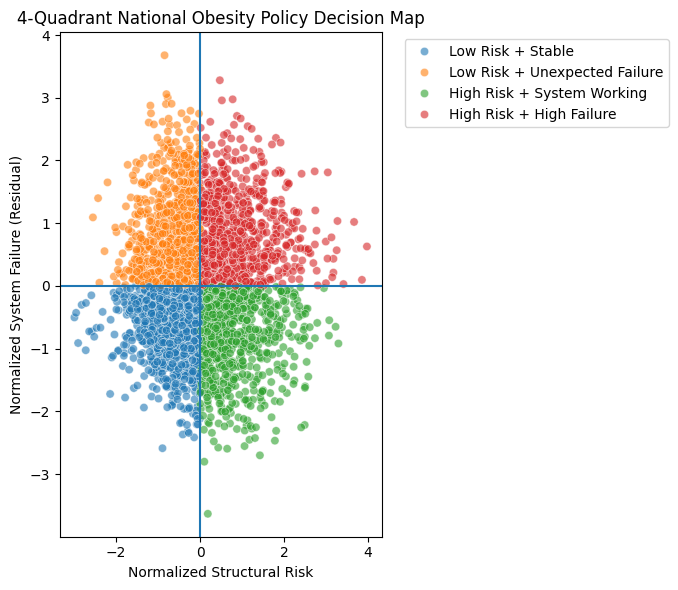

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df_final,
    x="risk_score_norm",
    y="residual_norm",
    hue="policy_group",
    alpha=0.6
)

plt.axvline(0)
plt.axhline(0)
plt.xlabel("Normalized Structural Risk")
plt.ylabel("Normalized System Failure (Residual)")
plt.title("4-Quadrant National Obesity Policy Decision Map")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Maps

In [ ]:
DASHBOARD_DATA = "/content/drive/MyDrive/obesity-risk-analytics/dashboard_data_final/"
with open(DASHBOARD_DATA + "counties_fips.geojson", "r") as f:
    counties_geojson = json.load(f)

In [ ]:
df_final[[
    "GEOID",
    "CTYNAME",
    "STNAME",
    "residual",
    "efficiency_score",
    "physical_inactivity_rate",
    "poverty_rate",
    "risk_score_all",
    "obesity_rate"
]].head(10)


,GEOID,CTYNAME,STNAME,residual,efficiency_score,physical_inactivity_rate,poverty_rate,risk_score_all,obesity_rate
0,09001,NaN,NaN,-0.042415,0.067739,0.189000,0.090000,-4.753117,0.222000
1,09003,NaN,NaN,0.018323,0.017963,0.209000,0.108000,-3.550985,0.293000
2,09007,NaN,NaN,-0.003063,0.014553,0.198000,0.070000,-4.577700,0.274000
3,09009,NaN,NaN,0.024377,0.054939,0.223000,0.120000,-1.910094,0.310000
4,09011,NaN,NaN,0.019567,0.053464,0.218001,0.078000,-2.466703,0.307001
5,09013,NaN,NaN,-0.019417,0.075405,0.185000,0.078000,-5.981239,0.253000
6,09015,NaN,NaN,0.003541,0.054036,0.223002,0.115001,-3.335717,0.290002
7,02020,Anchorage Municipality,Alaska,0.013025,0.088504,0.178000,0.095000,-4.112945,0.299000
8,02090,Fairbanks North Star Borough,Alaska,-0.007038,0.012926,0.202002,0.072000,-3.539989,0.281003
9,02170,Matanuska-Susitna Borough,Alaska,0.019010,0.051151,0.216044,0.096001,-1.798970,0.317001


In [ ]:
def plot_policy_map(df, column, title, color_scale="Viridis"):

    df = df.copy()
    df["GEOID"] = df["GEOID"].astype(str).str.zfill(5)

    fig = px.choropleth(
        df,
        geojson=counties_geojson,
        locations="GEOID",
        color=column,
        hover_name="CTYNAME",
        hover_data={
            "STNAME": True,
            "GEOID": True,
            "obesity_rate": True,
            "physical_inactivity_rate": True,
            "poverty_rate": True,
            "risk_score_all": True,
            "residual": True,
            "efficiency_score": True
        },
        color_continuous_scale=color_scale,
        scope="usa",
        title=title,
    )

    fig.update_traces(marker_line_width=0)
    fig.update_layout(height=650)
    fig.show()


In [ ]:
plot_policy_map(
    df_final,
    column="residual",
    title="National System Failure Map (Obesity Residuals)",
    color_scale="RdYlBu"
)

In [ ]:
plot_policy_map(
    df_final,
    column="efficiency_score",
    title="National Obesity Policy ROI Map (Inactivity Reduction Efficiency)",
    color_scale="RdYlBu"
)

In [ ]:
df_final.sort_values(
    "efficiency_score", ascending=False
).head(20)[[
    "CTYNAME", "STNAME",
    "physical_inactivity_rate",
    "obesity_reduction_potential",
    "efficiency_score"
]]


,CTYNAME,STNAME,physical_inactivity_rate,obesity_reduction_potential,efficiency_score
2682,Oglala Lakota County,South Dakota,0.238011,0.068435,0.287530
2142,Sunflower County,Mississippi,0.303003,0.084261,0.278085
478,Charles County,Maryland,0.244001,0.062016,0.254161
952,Hidalgo County,Texas,0.271000,0.066999,0.247227
68,Yuma County,Arizona,0.226001,0.053629,0.237297
2925,Emery County,Utah,0.181002,0.040711,0.224921
3003,Adams County,Washington,0.237017,0.052875,0.223085
73,Fresno County,California,0.234000,0.050641,0.216415
1126,Pierce County,Wisconsin,0.177004,0.037452,0.211587
2379,Thurston County,Nebraska,0.286040,0.060406,0.211181


/tmp/ipython-input-625175373.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



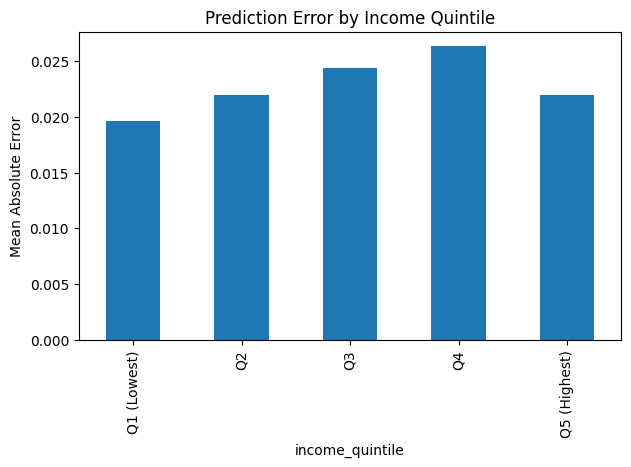

In [ ]:
# Create income quintiles
df_final["income_quintile"] = pd.qcut(
    df_final["median_household_income"],
    5,
    labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"]
)

# Compute absolute error
df_final["abs_error"] = np.abs(df_final["residual"])

# Group by income quintile
err_by_income = df_final.groupby("income_quintile")["abs_error"].mean()

# Plot
plt.figure(figsize=(7, 4))
err_by_income.plot(kind="bar")
plt.ylabel("Mean Absolute Error")
plt.title("Prediction Error by Income Quintile")
plt.show()
